In [46]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
import os

from wordcloud import WordCloud
from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix,
                             mean_squared_error, r2_score)

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

sns.set(style='whitegrid', palette='muted', font_scale=1.1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:

file_path = "/content/IMDB Dataset.csv"
df = pd.read_csv(file_path)
df.shape


(1000, 18)

In [48]:
display(df.head())
df.info()


,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,review,sentiment
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"2,83,41,469",One of the other reviewers has mentioned that ...,positive
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"13,49,66,411",A wonderful little production. <br /><br />The...,positive
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"53,48,58,444",I thought this was a wonderful way to spend ti...,positive
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"5,73,00,000",Basically there's a family where a little boy ...,negative
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"43,60,000","Petter Mattei's ""Love in the Time of Money"" is...",positive


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 15  Gross          831 non-null    object 
 16  review         1000 non-null   object 
 17  sentiment      1000 non-null   object 
dtypes: float6

In [49]:

print("Columns:", df.columns.tolist())
print("\nMissing values (top):")
print(df.isnull().sum().sort_values(ascending=False).head(30))


Columns: ['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate', 'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross', 'review', 'sentiment']

Missing values (top):
Gross            169
Meta_score       157
Certificate      101
Poster_Link        0
Series_Title       0
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Released_Year      0
Director           0
Star1              0
Star3              0
Star2              0
Star4              0
No_of_Votes        0
review             0
sentiment          0
dtype: int64


In [50]:

data = df.copy()


def parse_gross(x):
    try:

        s = re.sub(r'[^\d]', '', str(x))
        return int(s) if s!='' else np.nan
    except:
        return np.nan

data['Gross'] = data['Gross'].apply(parse_gross)

def parse_runtime(x):
    try:
        s = re.search(r'(\d+)', str(x))
        return int(s.group(1)) if s else np.nan
    except:
        return np.nan

data['Runtime_min'] = data['Runtime'].apply(parse_runtime)

data['Meta_score'] = pd.to_numeric(data['Meta_score'], errors='coerce')

data['No_of_Votes'] = pd.to_numeric(data['No_of_Votes'], errors='coerce')

# Released Year to numeric
data['Released_Year'] = pd.to_numeric(data['Released_Year'], errors='coerce')

# Create a primary genre column
data['primary_genre'] = data['Genre'].astype(str).apply(lambda x: x.split(',')[0].strip() if pd.notna(x) else x)

# Quick check
data[['Series_Title', 'Released_Year','Runtime_min','primary_genre','IMDB_Rating','Meta_score','Gross','No_of_Votes']].head()


,Series_Title,Released_Year,Runtime_min,primary_genre,IMDB_Rating,Meta_score,Gross,No_of_Votes
0,The Shawshank Redemption,1994.0,142,Drama,9.3,80.0,28341469.0,2343110
1,The Godfather,1972.0,175,Crime,9.2,100.0,134966411.0,1620367
2,The Dark Knight,2008.0,152,Action,9.0,84.0,534858444.0,2303232
3,The Godfather: Part II,1974.0,202,Crime,9.0,90.0,57300000.0,1129952
4,12 Angry Men,1957.0,96,Crime,9.0,96.0,4360000.0,689845


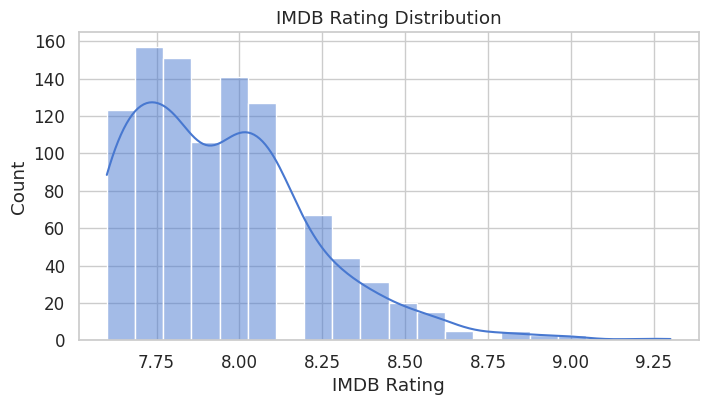

In [51]:
# Distribution of IMDB ratings
plt.figure(figsize=(8,4))
sns.histplot(data['IMDB_Rating'].dropna(), bins=20, kde=True)
plt.title('IMDB Rating Distribution')
plt.xlabel('IMDB Rating')
plt.show()


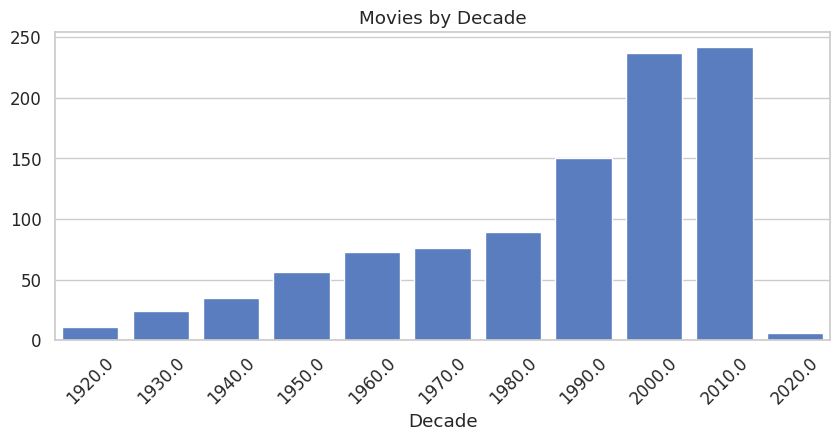

In [52]:
# Movies per decade
data['decade'] = (data['Released_Year']//10)*10
decade_counts = data['decade'].value_counts().sort_index()
plt.figure(figsize=(10,4))
sns.barplot(x=decade_counts.index.astype(str), y=decade_counts.values)
plt.xticks(rotation=45)
plt.title('Movies by Decade')
plt.xlabel('Decade')
plt.show()


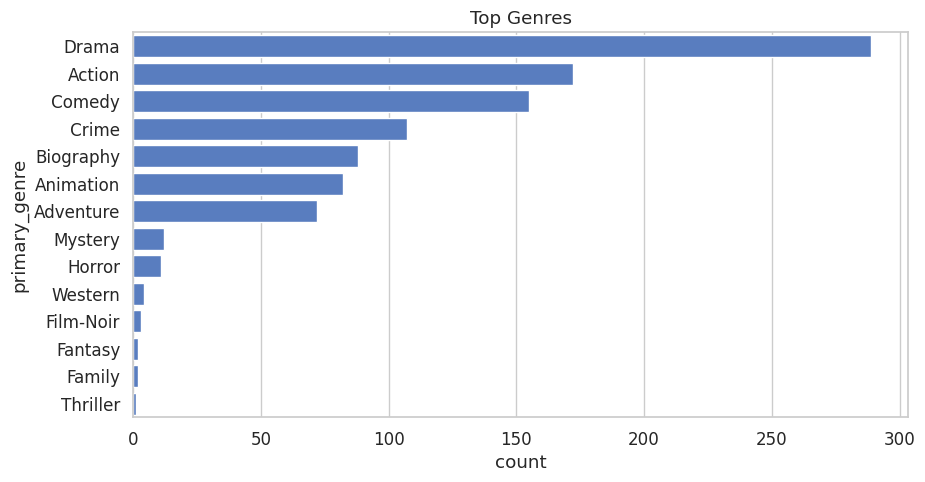

In [53]:
# Top 10 genres
plt.figure(figsize=(10,5))
sns.countplot(y='primary_genre', data=data, order=data['primary_genre'].value_counts().index[:15])
plt.title('Top Genres')
plt.show()


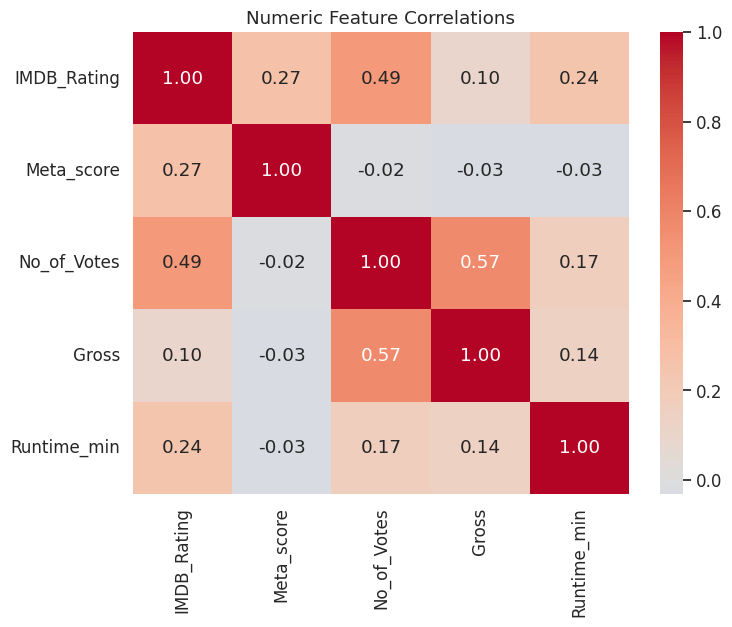

In [54]:

num_cols = ['IMDB_Rating','Meta_score','No_of_Votes','Gross','Runtime_min']
nc = data[num_cols].copy()
plt.figure(figsize=(8,6))
sns.heatmap(nc.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Numeric Feature Correlations')
plt.show()


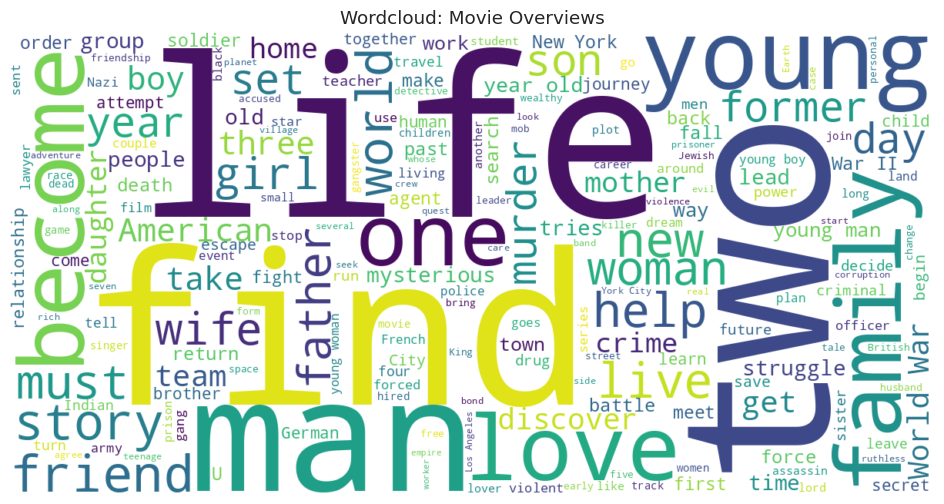

In [55]:
# Wordcloud for Overviews
from wordcloud import WordCloud
overview_text = ' '.join(data['Overview'].dropna().astype(str).values)
wc = WordCloud(width=1200, height=600, background_color='white', stopwords=STOPWORDS).generate(overview_text)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud: Movie Overviews')
plt.show()

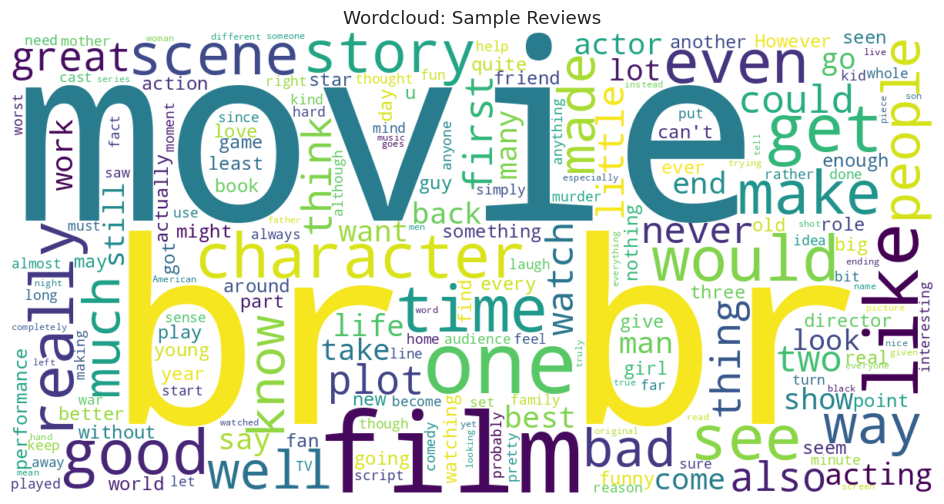

In [56]:
# Wordcloud for reviews
review_text = ' '.join(data['review'].dropna().astype(str).values[:500])  # limit to avoid heavy compute
wc2 = WordCloud(width=1200, height=600, background_color='white', stopwords=STOPWORDS).generate(review_text)
plt.figure(figsize=(12,6))
plt.imshow(wc2, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud: Sample Reviews')
plt.show()


sentiment
positive    501
negative    499
Name: count, dtype: int64


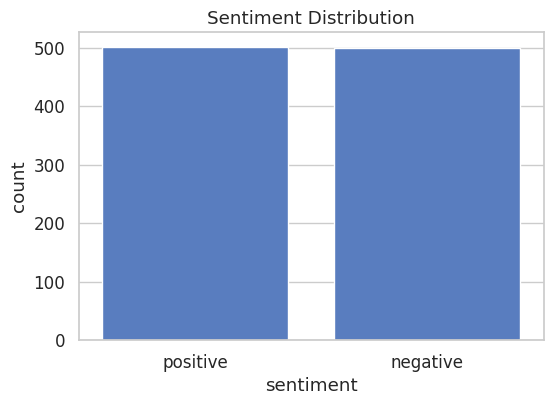

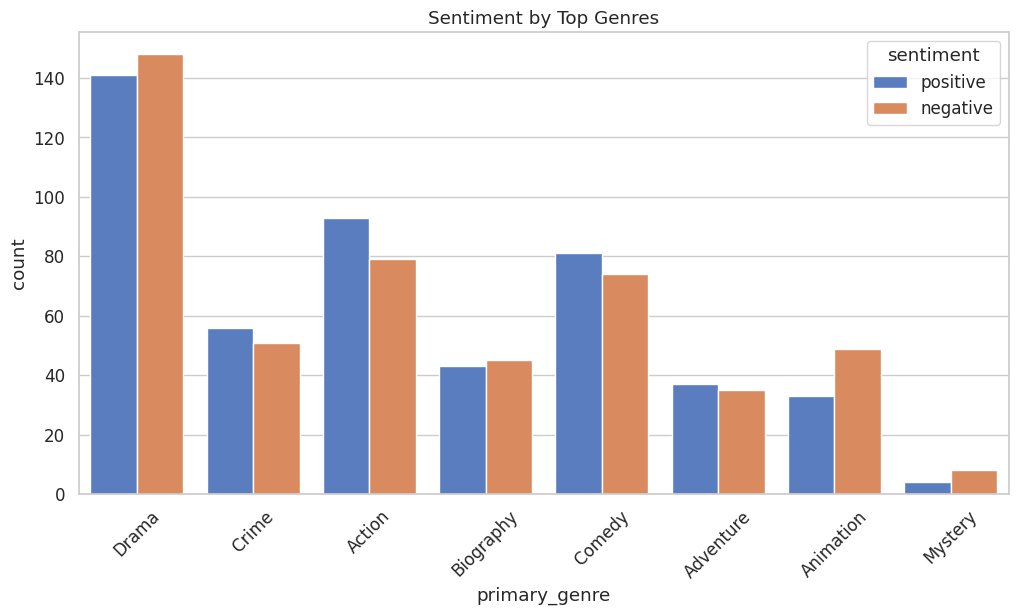

In [57]:
# Check sentiment distribution
print(data['sentiment'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=data)
plt.title('Sentiment Distribution')
plt.show()

# Sentiment by genre
top_genres = data['primary_genre'].value_counts().nlargest(8).index
plt.figure(figsize=(12,6))
sns.countplot(x='primary_genre', hue='sentiment', data=data[data['primary_genre'].isin(top_genres)])
plt.xticks(rotation=45)
plt.title('Sentiment by Top Genres')
plt.show()


In [58]:
# Prepare dataset: drop missing review & sentiment
sent_df = data[['review','sentiment']].dropna().copy()

sent_df['sentiment_label'] = sent_df['sentiment'].map({'positive':1, 'negative':0})
sent_df = sent_df[sent_df['review'].str.strip()!='']

# Train-test split
X = sent_df['review'].values
y = sent_df['sentiment_label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [59]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = text.lower()
    tokens = [w for w in text.split() if w not in STOPWORDS and len(w)>1]
    return ' '.join(tokens)

X_train_clean = [clean_text(t) for t in X_train]
X_test_clean = [clean_text(t) for t in X_test]


In [60]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words='english')

X_train_vec = tfidf.fit_transform(X_train_clean)
X_test_vec  = tfidf.transform(X_test_clean)

print("Train shape:", X_train_vec.shape, "Test shape:", X_test_vec.shape)


Train shape: (800, 10000) Test shape: (200, 10000)


In [61]:
lr = LogisticRegression(max_iter=300, solver='saga')  # saga handles l1/l2 and large n_features
lr.fit(X_train_vec, y_train)
y_pred_lr = lr.predict(X_test_vec)

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression
Accuracy: 0.825
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       100
           1       0.81      0.85      0.83       100

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200



In [62]:
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)
y_pred_nb = nb.predict(X_test_vec)

print("Naive Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naive Bayes
Accuracy: 0.82
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       100
           1       0.83      0.80      0.82       100

    accuracy                           0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.82      0.82      0.82       200



In [63]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)



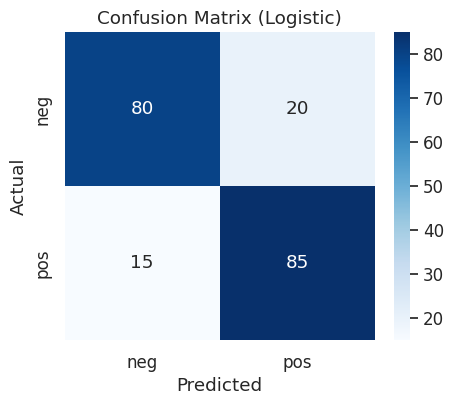

In [64]:
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['neg','pos'], yticklabels=['neg','pos'])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix (Logistic)')
plt.show()


In [65]:
def predict_sentiment(text, model, vectorizer):
    txt_clean = clean_text(text)
    vec = vectorizer.transform([txt_clean])
    pred = model.predict(vec)[0]
    return 'positive' if pred==1 else 'negative'

# Save the trained model and vectorizer
if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(lr, 'models/sentiment_logistic.pkl')
joblib.dump(tfidf, 'models/tfidf_vectorizer.pkl')

# Test
model_loaded = joblib.load('models/sentiment_logistic.pkl')
vec_loaded = joblib.load('models/tfidf_vectorizer.pkl')
print(predict_sentiment("I loved this movie, it was brilliant and fun!", model_loaded, vec_loaded))
print(predict_sentiment("Terrible movie. The plot was a mess.", model_loaded, vec_loaded))

positive
negative


In [66]:
reg_df = data[['IMDB_Rating','Meta_score','No_of_Votes','Gross','Runtime_min','primary_genre']].copy()

reg_df = reg_df.dropna(subset=['IMDB_Rating'])
reg_df['Meta_score'] = reg_df['Meta_score'].fillna(reg_df['Meta_score'].median())
reg_df['Gross'] = reg_df['Gross'].fillna(reg_df['Gross'].median())
reg_df['Runtime_min'] = reg_df['Runtime_min'].fillna(reg_df['Runtime_min'].median())
reg_df['No_of_Votes'] = reg_df['No_of_Votes'].fillna(reg_df['No_of_Votes'].median())

reg_df = pd.get_dummies(reg_df, columns=['primary_genre'], drop_first=True)

# Train-test split
X = reg_df.drop(columns=['IMDB_Rating'])
y = reg_df['IMDB_Rating']
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y, test_size=0.2, random_state=42)


In [67]:
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_reg.fit(X_train_r, y_train_r)
y_pred_r = rf_reg.predict(X_test_r)

print("Regression Results (RandomForest)")
print("RMSE:", mean_squared_error(y_test_r, y_pred_r)**0.5)
print("R2:", r2_score(y_test_r, y_pred_r))

Regression Results (RandomForest)
RMSE: 0.1900981259770852
R2: 0.43627078653438567


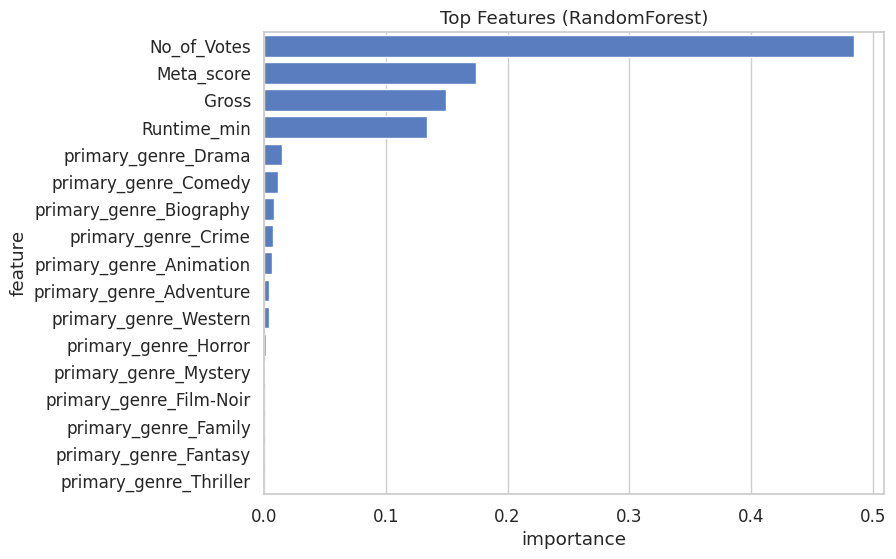

In [68]:
importances = rf_reg.feature_importances_
feat_names = X_train_r.columns
feat_imp = pd.DataFrame({'feature':feat_names, 'importance':importances}).sort_values('importance', ascending=False).head(20)
plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=feat_imp)
plt.title('Top Features (RandomForest)')
plt.show()


In [69]:
joblib.dump(rf_reg, 'models/rating_rf_regressor.pkl')
print("Saved regression model.")


Saved regression model.


In [70]:
os.makedirs('visuals', exist_ok=True)

# Save ratings distribution
plt.figure(figsize=(8,4))
sns.histplot(data['IMDB_Rating'].dropna(), bins=20, kde=True)
plt.title('IMDB Rating Distribution')
plt.savefig('visuals/ratings_distribution.png', bbox_inches='tight')
plt.close()

# Save wordcloud
wc.to_file('visuals/overview_wordcloud.png')
wc2.to_file('visuals/reviews_wordcloud.png')


In [71]:
import streamlit as st
import joblib

model = joblib.load('models/sentiment_logistic.pkl')
vectorizer = joblib.load('models/tfidf_vectorizer.pkl')

st.title("IMDB Review Sentiment Predictor")
review = st.text_area("Enter a movie review:")
if st.button("Predict"):
    from re import sub
    text = sub(r'<.*?>', ' ', review)
    text = sub(r'[^a-zA-Z0-9\s]', ' ', text).lower()
    pred = model.predict(vectorizer.transform([text]))[0]
    st.write("Prediction:", "Positive" if pred==1 else "Negative")


2025-09-18 10:36:45.210 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-18 10:36:45.211 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-18 10:36:45.214 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-18 10:36:45.215 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-18 10:36:45.218 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-18 10:36:45.219 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-18 10:36:45.220 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-18 10:36:45.221 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar